In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale, bands, topological_gap
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:32<00:00,  2.47s/it]


### Initial voltage guess

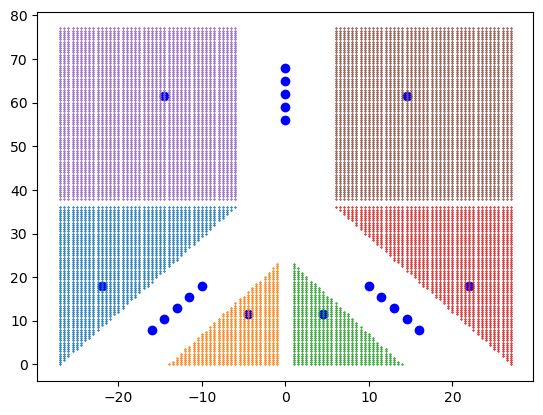

In [11]:
site_coords = system.grid_points[system.site_indices]
for gate, index in system.indices.items():
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

# plt.scatter(points[:, 0], points[:, 1])

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [ ]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

#### Optimize potential shape

In [9]:
optimal_voltages = {}
optimal_phase = {}
for pair in ['left-top']:
    
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params['dep_acc_index'] = system.indices

    args = (pair.split('-'),
            (system.base_ham, system.linear_terms, system.densityoperator),
            system.indices, 
            )

    initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

    sol1 = minimize(codes.optimization.shape_loss, 
             x0=initial_condition, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3}
            )

    print(sol1.x)

    ci, wf_amp = 50, 1e-4
    args = ((system.base_ham, 
            params, 
            system.linear_terms, 
            system.f_params, 
            system.densityoperator),
            (pair.split('-'), system.indices, (ci, wf_amp))
           )

    sol2 = minimize(codes.optimization.wavefunction_loss, 
             x0=sol1.x, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3,
                     'verbose':2}
            )

    print(sol2.x)

    params.update(parameters.voltage_dict(sol2.x))
    
    args = (pair, 
            params, 
            (system.trijunction, system.linear_terms, 
             system.f_params, system.densityoperator, 
             system.mlwf[order_wavefunctions(pair)]
            )
           )

    sol3 = minimize_scalar(codes.optimization.loss, 
                             args=args, 
                             method='bounded', 
                             bounds=(0,2)
                          )

    
    optimal_phase[pair] = sol3.x * np.pi
    
    print(optimal_phase[pair])

    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    params.update(potential=system.flat_potential())
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    args = (pair, 
            params, 
            (base_ham, system.linear_terms, 
             system.f_params, system.densityoperator, 
             system.mlwf[order_wavefunctions(pair)]
            )
           )

    sol4 = minimize(codes.optimization.loss, 
             x0=sol2.x, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3,
                     'verbose':2}
            )
    
    optimal_voltages[pair] = parameters.voltage_dict(sol4.x)
    
    print(optimal_voltages[pair])

[-0.00344554 -0.00690489 -0.00318008  0.00081576]
[3.86422547e-06 1.14507790e-05] 7.586553576516764e-06 1.514647842627992e-07
[3.86414981e-06 1.14507771e-05] 7.586627336250914e-06 1.5146460017137098e-07
[3.86422032e-06 1.14507771e-05] 7.586556824695837e-06 1.5146297579473872e-07
[3.86422351e-06 1.14505196e-05] 7.586296064622016e-06 1.514646736375963e-07
[3.86426263e-06 1.14508836e-05] 7.586620977479524e-06 1.5146574503658565e-07
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -6.2138e-06 | 1.00e-03 | 1.00e-02 | 0.00e+00 |
[2.09470278e-05 1.52465608e-05] 5.700467014819352e-06 2.1258230022383208e-07
[2.09464610e-05 1.52465581e-05] 5.699902980739503e-06 2.1258051784720636e-07
[2.09469889e-05 1.52465581e-05] 5.700430817130361e-06 2.1257997803443587e-07
[2.09470130e-05 1.52461955e-05] 5.700817471314563e-06 2.125821037996355e-07
[2.09472963e-05 1.52467074e-05] 5.7005889

KeyboardInterrupt: 

#### Results

1.1006798298427053e-05 1.6594150246077368e-07


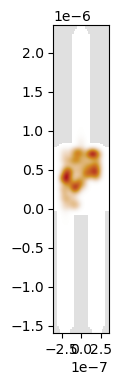

In [11]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

for i, pair in enumerate(['left-top']):
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    # params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    params.update(parameters.voltage_dict([0.00132302, 
                                          -0.00702831,  
                                          0.00175367,  
                                          0.00481254]))
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    linear_ham, full_ham = hamiltonian(system.base_ham, 
                                       system.linear_terms, 
                                       **params
                                      )

    potential = linear_ham.diagonal()[::4]
    # step_potential = np.array(np.abs(potential) > bands[0], dtype=int)

    evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

    transformed_hamiltonian = svd_transformation(
        evals, evecs, system.mlwf[order_wavefunctions(pair)]
    )

    desired = np.abs(transformed_hamiltonian[0, 1])
    undesired = np.linalg.norm(transformed_hamiltonian[2:])
    
    print(desired, undesired)
    wfv = system.densityoperator(evecs[:, 0])

    # kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
    kwant.plotter.density(system.trijunction, wfv, ax = ax);
    # ax.set_title(np.round(desired/topological_gap, 3))
    # for value in system.indices.values():
    #     ax[0].scatter(*kwant_sites[value], c='blue')
    
    # voltages = list(optimal_voltages[pair].values())
    # print(pair + ':', np.array(voltages)[list(range(0, 7, 2))])
# for axes in ax:
#     axes.set_ylim(-3e-7, 10e-7)
#     axes.set_xlim(-3e-7, 3e-7)
#     axes.set_xlabel('X (nm)')
#     axes.set_ylabel('Y (nm)')
    
# fig.tight_layout()

### Debugging

In [12]:
pair = 'left-right'

In [59]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params['dep_acc_index'] = system.indices

args = (pair.split('-'),
        (system.base_ham, system.linear_terms, system.densityoperator),
        system.indices, 
        )

initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

sol1 = minimize(codes.optimization.shape_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3}
        )

print('Potential')

Potential


In [108]:
import codes.optimization
# import codes.utils
# importlib.reload(codes.utils)
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [90]:
ci, wf_amp = 50, 1e-4
args = ((system.base_ham, 
        params, 
        system.linear_terms, 
        system.f_params, 
        system.densityoperator),
        (pair.split('-'), system.indices, (ci, wf_amp))
       )


sol2 = minimize(codes.optimization.wavefunction_loss, 
         x0=sol1.x, 
         args=args, 
         method='trust-constr',
         options={'initial_tr_radius':1e-3,
                  'verbose':2,
                  'gtol':1e-4
                 }
        )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +3.7542e-07 | 1.00e-03 | 1.32e-03 | 0.00e+00 |
|   2   |  10   |   1   | -1.3991e-06 | 7.00e-03 | 2.85e-03 | 0.00e+00 |
|   3   |  15   |   2   | -2.3107e-06 | 7.00e-03 | 4.49e-03 | 0.00e+00 |
|   4   |  20   |   3   | -5.0367e-06 | 7.00e-03 | 9.98e-03 | 0.00e+00 |
|   5   |  25   |   4   | -8.7852e-06 | 7.00e-03 | 4.25e-02 | 0.00e+00 |
|   6   |  30   |   5   | -2.0950e-05 | 7.00e-03 | 1.20e-01 | 0.00e+00 |
|   7   |  35   |   7   | -2.0950e-05 | 7.00e-04 | 1.20e-01 | 0.00e+00 |
|   8   |  40   |   9   | -2.0950e-05 | 3.50e-04 | 1.20e-01 | 0.00e+00 |
|   9   |  45   |  11   | -2.0950e-05 | 1.75e-04 | 1.20e-01 | 0.00e+00 |
|  10   |  50   |  12   | -4.4039e-05 | 1.23e-03 | 1.33e-01 | 0.00e+00 |
|  11   |  55   |  15   | -4.4039e-05 | 1.44e-04 | 1.33e-01 | 0.00e+00 |
|  12   |  60   |  16   | -4.6714e-05 | 1.44e-04 | 

In [96]:
%%time

params.update(parameters.voltage_dict(sol2.x))
    
args = (pair, 
        params, 
        (system.trijunction, system.linear_terms, 
         system.f_params, system.densityoperator, 
         system.mlwf[order_wavefunctions(pair)]
        )
       )

sol3 = minimize_scalar(codes.optimization.loss, 
                         args=args, 
                         method='bounded', 
                         bounds=(0,2)
                      )

0.7639320225002102
2.6436738177946956e-05 3.150770724438882e-07
1.2360679774997896
2.051619863864676e-05 2.3376169091079114e-07
0.4721359549995794
2.1245416544532225e-05 1.0117508466516178e-07
0.839458151169804
2.6703511619735003e-05 4.638420613110702e-07
0.8202146473689204
2.6685349566042616e-05 4.159692014305102e-07
0.8158497459815386
2.6676444784489574e-05 4.063156548261604e-07
0.8165567349814835
2.6678006827892236e-05 4.078526566957809e-07
0.8165162520954422
2.6677918632169996e-05 4.0776437437330836e-07
0.8165195975396687
2.66779259262793e-05 4.077716686286732e-07
0.8165129066512157
2.6677911337024128e-05 4.0775708032121966e-07
CPU times: user 1min 5s, sys: 14.3 s, total: 1min 19s
Wall time: 1min 19s


In [112]:
params.update(parameters.phase_pairs(pair, sol3.x * np.pi))
    
args = (pair, 
        params, 
        (system.base_ham, system.linear_terms, 
         system.f_params, system.densityoperator, 
         system.mlwf[order_wavefunctions(pair)]
        )
       )

sol4 = minimize(codes.optimization.loss, 
         x0=sol2.x, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3,
                 'verbose':2}
        )

[-0.00149421 -0.00647917 -0.00204598  0.00394987  0.81651625]
2.6677918632169152e-05 4.0776437437321524e-07
[-0.00149422 -0.00647917 -0.00204598  0.00394987  0.81651625]
2.6678018488062095e-05 4.077662386359124e-07
[-0.00149421 -0.00647919 -0.00204598  0.00394987  0.81651625]
2.6677986057509108e-05 4.077656240364597e-07
[-0.00149421 -0.00647917 -0.002046    0.00394987  0.81651625]
2.6679242209879655e-05 4.077893199857096e-07
[-0.00149421 -0.00647917 -0.00204598  0.00394989  0.81651625]


KeyboardInterrupt: 

In [91]:
params.update(parameters.voltage_dict(sol2.x))

linear_ham, full_ham = hamiltonian(system.base_ham, 
                               system.linear_terms, 
                               system.f_params, 
                               **params)

potential = linear_ham.diagonal()[::4]
# step_potential = np.array(np.abs(potential) > bands[0], dtype=int)

evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

transformed_hamiltonian = svd_transformation(
    evals, evecs, system.mlwf[order_wavefunctions(pair)]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

wfv = system.densityoperator(evecs[:, 0])

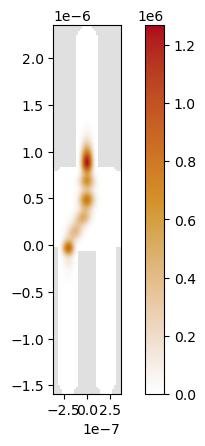

In [92]:
kwant.plotter.density(system.trijunction, wfv);